In [ ]:
# ========================================
# 🧰 Install all dependencies (Colab setup)
# ========================================
!pip install -q tensorflow opencv-python-headless matplotlib seaborn scikit-learn numpy


In [ ]:
import zipfile

# ========================================
# 📦 Extract dataset zip
# ========================================

# Replace 'your_file.zip' with the actual filename
filename = "fer2013.zip"

if filename.endswith(".zip"):
    print(f"Extracting {filename}...")
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall("./")
    print("✅ Extraction complete!")
else:
    print("The file is not a ZIP file.")


Extracting fer2013.zip...
✅ Extraction complete!


In [ ]:
# ========================================
# 🧠 Emotion Detection Model — Training
# ========================================

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns

print(f"✅ TensorFlow version: {tf.__version__}")
print(f"GPU detected: {tf.config.list_physical_devices('GPU')}")

# ==============================
# 📂 Dataset Paths
# ==============================
train_dir = 'fer2013/train'
test_dir = 'er2013/test'

# ==============================
# 🔄 Data Augmentation
# ==============================
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.7, 1.3],
    horizontal_flip=True,
    validation_split=0.2,
    fill_mode='nearest',
    #contrast_stretching=True  # if available in your library
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    batch_size=64,
    color_mode='grayscale',
    class_mode='categorical',
    subset='training',
    seed=42
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    batch_size=64,
    color_mode='grayscale',
    class_mode='categorical',
    subset='validation',
    seed=42
)

# ==============================
# 🧱 Model Architecture
# ==============================
def build_custom_cnn(input_shape=(48, 48, 1), num_classes=7):
    l2_reg = 1e-4
    model = models.Sequential([
        layers.Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(l2_reg), input_shape=input_shape),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(l2_reg)),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.MaxPooling2D(2),
        layers.Dropout(0.3),

        layers.Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(l2_reg)),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(l2_reg)),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.MaxPooling2D(2),
        layers.Dropout(0.4),

        layers.Conv2D(256, (3,3), padding='same', kernel_regularizer=regularizers.l2(l2_reg)),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Conv2D(256, (3,3), padding='same', kernel_regularizer=regularizers.l2(l2_reg)),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.MaxPooling2D(2),
        layers.Dropout(0.5),

        #layers.Flatten(),
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.6),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

model = build_custom_cnn()
model.summary()

# ==============================
# ⚙️ Compile & Train
# ==============================
def lr_schedule(epoch):
    initial_lr = 1e-3
    if epoch > 40:
        return initial_lr * 0.1
    elif epoch > 25:
        return initial_lr * 0.5
    return initial_lr

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1),
    LearningRateScheduler(lr_schedule)
]

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=60,
    callbacks=callbacks
)

model.save('emotion_model_optimized.h5')
print("✅ Model trained and saved successfully!")


✅ TensorFlow version: 2.19.0
GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Found 22999 images belonging to 7 classes.
Found 5747 images belonging to 7 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 12, 12, 256)    │             

 Total params: 1,285,063 (4.90 MB)

 Trainable params: 1,282,247 (4.89 MB)

 Non-trainable params: 2,816 (11.00 KB)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/60
360/360 ━━━━━━━━━━━━━━━━━━━━ 70s 145ms/step - accuracy: 0.1856 - loss: 2.4595 - precision: 0.1846 - recall: 0.0429 - val_accuracy: 0.2516 - val_loss: 1.9154 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/60
360/360 ━━━━━━━━━━━━━━━━━━━━ 37s 103ms/step - accuracy: 0.2201 - loss: 2.0396 - precision: 0.1779 - recall: 0.0087 - val_accuracy: 0.2382 - val_loss: 1.9142 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/60
360/360 ━━━━━━━━━━━━━━━━━━━━ 37s 104ms/step - accuracy: 0.2405 - loss: 1.9407 - precision: 0.2526 - recall: 0.0046 - val_accuracy: 0.2579 - val_loss: 1.9835 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/60
360/360 ━━━━━━━━━━━━━━━━━━━━ 37s 103ms/step - accuracy: 0.2625 - loss: 1.8906 - precision: 0.3153 - recall: 0.0050 - val_accuracy: 0.1909 - val_loss: 2.0035 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/60
360/360 ━

✅ Model trained and saved successfully!


In [ ]:
# ========================================
# 🎥 Real-time emotion detection (local use only)
# ========================================

import cv2
import numpy as np
from tensorflow.keras.models import load_model

model = load_model('emotion_model_optimized.h5')

emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
haar_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

cap = cv2.VideoCapture(0)
print("🎥 Press 'q' to quit")

while True:
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = haar_cascade.detectMultiScale(gray, 1.1, 5)

    for (x, y, w, h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_gray = cv2.resize(roi_gray, (48,48))
        roi = roi_gray.astype('float32')/255.0
        roi = np.expand_dims(roi, axis=(0,-1))
        preds = model.predict(roi, verbose=0)[0]
        label = emotion_labels[np.argmax(preds)]
        prob = np.max(preds)

        cv2.rectangle(frame, (x,y), (x+w, y+h), (0,255,0), 2)
        cv2.putText(frame, f"{label}: {prob:.2f}", (x, y-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2, cv2.LINE_AA)

    cv2.imshow("Emotion Detection", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


🎥 Press 'q' to quit


Saving WhatsApp Image 2025-10-31 at 09.10.39_d83a0ce0.jpg to WhatsApp Image 2025-10-31 at 09.10.39_d83a0ce0.jpg


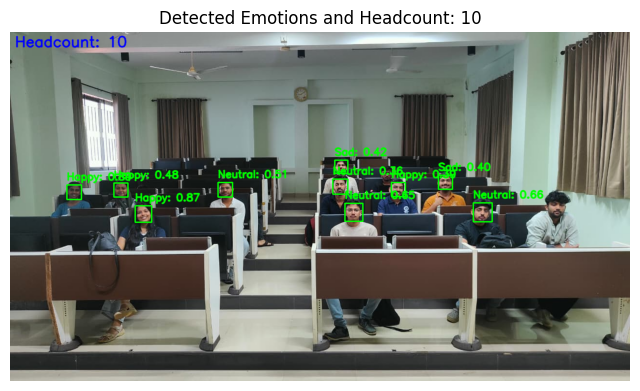

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from google.colab import files

# Load pre-trained emotion detection model and emotion labels
model = load_model('emotion_model_optimized.h5')
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

# Load Haar Cascade for face detection
haar = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Upload image
uploaded = files.upload()
img_path = list(uploaded.keys())[0]
img = cv2.imread(img_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Detect faces in the image
faces = haar.detectMultiScale(gray, 1.1, 5)

# Draw bounding boxes and predict emotions for each face
headcount = len(faces)  # Count number of faces detected
for (x, y, w, h) in faces:
    roi = gray[y:y+h, x:x+w]
    roi = cv2.resize(roi, (48,48))
    roi = roi.astype('float32') / 255.0
    roi = np.expand_dims(roi, axis=(0,-1))
    preds = model.predict(roi, verbose=0)[0]
    label = emotion_labels[np.argmax(preds)]
    prob = np.max(preds)

    # Draw rectangle around face and add emotion label
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
    cv2.putText(img, f"{label}: {prob:.2f}", (x, y-10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2, cv2.LINE_AA)

# Display headcount on the image
cv2.putText(img, f"Headcount: {headcount}", (10, 30),
            cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)

# Convert BGR image to RGB for display
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Plot the image with detected emotions and headcount
plt.figure(figsize=(8, 8))
plt.imshow(img_rgb)
plt.axis('off')
plt.title(f'Detected Emotions and Headcount: {headcount}')
plt.show()


In [ ]:
import tensorflow as tf
print(tf.__version__)


2.19.0
